# Attack Analysis

This notebook downloads all experiment data from the database and analyzes it in various ways. Most importantly, it collects insights in the form of Python expressions, which can be pasted into the plots notebook where they are then visualized.

In [1]:
import os
import pickle
from itertools import combinations
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import gb

## Retrieve Data

In [2]:
def fetch_remaining(exs, collection, filter_dict):
    filter_dict["status"] = "COMPLETED"
    if len(exs) != 0:
        filter_dict["_id"] = {"$nin": [ex["_id"] for ex in exs]}
    fetched = gb.util.fetch(
        collection, ["config", "result"], filter_dict,
        incl_files={"perturbations", "proba_margins"}
    )
    for ex in fetched:
        if "evasion_run_id" in ex.config:
            evasion_run_id = ex.config.evasion_run_id
            ev_ex = next(ev_ex for ev_ex in all_evasion_exs if ev_ex._id == evasion_run_id)
            ex.config |= ev_ex.config
            ex.result |= {k: v for k, v in ev_ex.result.items() if k not in ex.result}
    exs += fetched
    exs.sort(key=lambda ex: ex._id)

In [3]:
if "all_evasion_exs" not in globals():
    all_evasion_exs = []
fetch_remaining(all_evasion_exs, "evasion", {})

In [4]:
if "all_trans_poisoning_exs" not in globals():
    all_trans_poisoning_exs = []
fetch_remaining(all_trans_poisoning_exs, "trans_poisoning", {})

In [5]:
if "cross_model_evasion_exs" not in globals():
    cross_model_evasion_exs = []
fetch_remaining(cross_model_evasion_exs, "cross_model_evasion", {})

In [6]:
if "cross_model_poisoning_exs" not in globals():
    cross_model_poisoning_exs = []
fetch_remaining(cross_model_poisoning_exs, "cross_model_poisoning", {})

Collect the experiments that should enter the big robustness evaluation:

In [7]:
main_evasion_exs = [ex for ex in all_evasion_exs if "feats" not in ex.config.attack.method]
main_trans_poisoning_exs = [ex for ex in all_trans_poisoning_exs if "feats" not in ex.config.attack.method and ex.config.get("use_evasion_seeds") != True]

## Sanity Checks

In [8]:
for ex in all_evasion_exs:
    for split_key, split_dict in ex.result.perturbations.items():
        for target_key, target_dict in split_dict.items():
            for budget_key, pert_dict in target_dict.items():
                permitted_budget = int(budget_key[7:])
                used_budget = len(pert_dict.get("edges", [])) + len(pert_dict.get("feats", []))
                if used_budget > permitted_budget:
                    print(f"{split_key} {target_key} {budget_key}: Used more budget ({used_budget}) than permitted ({permitted_budget})")

The following sanity check complains about some global experiments which have the same attack tags; they differ only in their `init_from_run_id` config field, which is not directly mapped to tags as it would differs across local experiments which should actually belong to the same "tag group".

In [9]:
num_local_targets = len(gb.data.get_all_benchmark_targets())
for exs in gb.ana.group(all_evasion_exs, lambda ex: (ex.config.dataset, gb.ana.model_slug(ex), ex.config.attack.scope, hash(frozenset(gb.ana.attack_tags(ex).items())))).values():
    scope = exs[0].config.attack.scope
    if scope == "global" and len(exs) != 1 or scope == "local" and len(exs) != num_local_targets:
        print("Too few/many experiments:", [ex._id for ex in exs])
        print("    ... with attack tags", gb.ana.attack_tags(exs[0]))

Too few/many experiments: [4346, 4347]
    ... with attack tags {'method': 'pgd_meta_edges', 'aggregation': 'tanh_score_margin', 'init': True}
Too few/many experiments: [4413, 4414]
    ... with attack tags {'method': 'pgd_meta_edges', 'aggregation': 'tanh_score_margin', 'init': True}
Too few/many experiments: [4348, 4349]
    ... with attack tags {'method': 'pgd_meta_edges', 'aggregation': 'tanh_score_margin', 'init': True}
Too few/many experiments: [4350, 4351]
    ... with attack tags {'method': 'pgd_meta_edges', 'aggregation': 'tanh_score_margin', 'init': True}


## Extract Unit Test

We extract perturbations that can serve as a more advanced black-box unit test to evalute novel defenses. This does however not replace a proper adaptive evaluation. To make the unit test self-contained, we also include our versions of Coral ML and Citeseer, as well as our exact data splits.

In [10]:
labeled_unproj_slugs = {
    "gcn_2": "gcn", "jaccard_gcn_tuned": "jaccard_gcn", "svd_gcn_rank50_tuned": "svd_gcn", "rgcn_tuned": "rgcn",
    "pro_gnn_tuned": "pro_gnn", "gnn_guard_faith_refimpl": "gnn_guard", "grand_tuned": "grand",
    "soft_median_gdc_tuned": "soft_median_gdc"
}

arrs_by_file = {}
for dataset in ["cora", "citeseer"]:
    path_dataset = dataset.replace("cora", "cora_ml")

    A, X, y = gb.data.get_dataset(dataset)
    splits = gb.data.get_splits(y)
    arrs_by_file[f"{path_dataset}/dataset/adjacency"] = A.triu().to_sparse().indices().numpy().T
    arrs_by_file[f"{path_dataset}/dataset/features"] = X.to_sparse().indices().numpy().T
    arrs_by_file[f"{path_dataset}/dataset/labels"] = y.numpy()
    for split_idx, split in enumerate(splits):
        for part_label, part in zip(["train", "val", "test"], split):
            arrs_by_file[f"{path_dataset}/splits/{split_idx}/{part_label}"] = part.numpy()

    for scenario, scenario_exs in [("evasion", main_evasion_exs), ("poisoning", main_trans_poisoning_exs)]:
        dataset_exs = [ex for ex in scenario_exs if ex.config.dataset == dataset and ex.config.attack.scope == "global"]
        for slug_label, slug in zip(labeled_unproj_slugs.values(), gb.ana.project_model_slugs(labeled_unproj_slugs.keys(), dataset)):
            model_exs = [ex for ex in dataset_exs if gb.ana.model_slug(ex) == slug]
            best_perts = gb.ana.find_perturbations_on_mr_envelope(model_exs)
            for split_key, split_dict in best_perts.items():
                for ub_key, (ub_dict, _, _) in split_dict.items():
                    path = f"{path_dataset}/perturbations/{scenario}/{slug_label}/{split_key.replace('=', '_')}/{ub_key.replace('used_budget=', 'budget_')}"
                    arrs_by_file[path] = ub_dict["edges"]

np.savez_compressed("unit_test.npz", **arrs_by_file)

## Preliminary Feature-Based Attacks

The following plots visualize the results of our preliminary experiments on the robustness of SVD-GCN against feature perturbations generated by Nettack. As SVD-GCN is the only defense from our selection which does claim robustness against feature perturbations, and considering that it either has little merit or is even detrimental to robustness in the majority of cases below, we decided to not study feature perturbations further and instead focus only on structure perturbations.

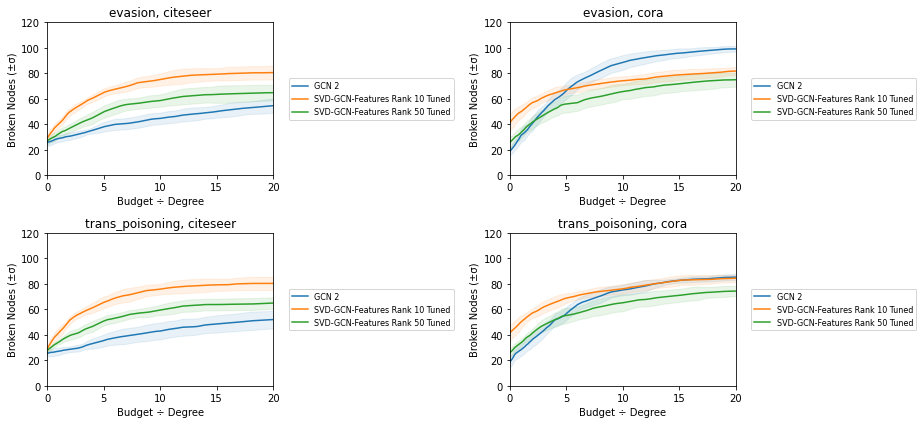

In [11]:
plt.figure(figsize=(13, 6))
gb.ana.plot_shuffler(
    all_evasion_exs + all_trans_poisoning_exs,
    filt=lambda ex: ex.config.attack.method == "nettack_feats",
    agrp=lambda ex: f"{ex.collection}, {ex.config.dataset}",
    pgrp=lambda ex: gb.ana.model_label(ex),
    plot=lambda exs, label: gb.ana.plot_sum_of_envelopes_of_local_break_curves(exs, label=label),
    conf=lambda: (plt.xlim(right=20), plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=8))
)

## Shared

In [12]:
def format_arr(arr):
    if arr.ndim == 1:
        return "[" + ", ".join(f"{v:.5g}".replace("nan", "np.nan") for v in arr) + "]"
    else:
        return "[" + ", ".join(format_arr(part) for part in arr) + "]"

# Main Paper

What follows are the Python expressions which can be pasted into the plots notebook to generate the plots from the main paper.

## Improvement over Non-Adaptive Attacks

In [13]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]

def describe_breakage(budget, exs):
    curve, alc_per_split = gb.ana.summarize_breakage(exs)
    ys_at_budget = curve.at(budget)
    return ys_at_budget.mean(), ys_at_budget.std(), alc_per_split.mean(), alc_per_split.std()

global_breakage = {
    (scenario, dataset): {
        slug: (
            describe_breakage(budget, slug_exs),
            describe_breakage(budget, [ex for ex in slug_exs if ex.config.get("from_model_slug") == "gcn_1"])
        )
        for slug, slug_exs in gb.ana.group(dataset_exs, gb.ana.model_slug).items()
        if slug in gb.ana.project_model_slugs(unproj_slugs, dataset)
    }
    for scenario, budget, scenario_exs in [("evasion", 0.05, main_evasion_exs + cross_model_evasion_exs), ("poisoning", 0.025, main_trans_poisoning_exs + cross_model_poisoning_exs)]
    for dataset, dataset_exs in gb.ana.group(filter(lambda ex: ex.config.attack.scope == "global", scenario_exs), lambda ex: ex.config.dataset).items()
    if dataset in ("cora", "citeseer")
}

local_budget = 1
local_breakage = {
    (scenario, dataset): {
        slug: (
            describe_breakage(local_budget, slug_exs),
            describe_breakage(local_budget, [ex for ex in slug_exs if ex.config.attack.method == "nettack_edges" and ex.config.attack.surrogate is not None and len(ex.config.attack.edge_diff_masks) == 0])
        )
        for slug, slug_exs in gb.ana.group(dataset_exs, gb.ana.model_slug).items()
        if slug in gb.ana.project_model_slugs(unproj_slugs, dataset)
    }
    for scenario, scenario_exs in [("evasion", main_evasion_exs), ("poisoning", main_trans_poisoning_exs)]
    for dataset, dataset_exs in gb.ana.group(filter(lambda ex: ex.config.attack.scope == "local", scenario_exs), lambda ex: ex.config.dataset).items()
    if dataset in ("cora", "citeseer")
}

breakage = {"global": global_breakage, "local": local_breakage}

print(f"breakage = {breakage}")

breakage = {'global': {('evasion', 'citeseer'): {'gcn_2': ((0.33865711082843786, 0.011650147337489956, 0.029863154313731672, 0.010260593384112407), (0.31603220491988265, 0.014305811580017027, 0.04746100254386716, 0.015528180446024272)), 'gnn_guard_faith_refimpl': ((0.367377213662422, 0.015489228968724908, 0.01404520518022356, 0.005554523873341695), (0.3069868853281176, 0.013905564098943123, 0.055714248758985896, 0.026199142092568635)), 'grand_tuned': ((0.3079907431186235, 0.006388728732395411, 0.05467159203823777, 0.009308955907838848), (0.26366959786111605, 0.004801685132073833, 0.1869150968003662, 0.018308744049306318)), 'jaccard_gcn_tuned': ((0.340447191404567, 0.009948576043597699, 0.030060569544096027, 0.010299666171851525), (0.29673439265848156, 0.011409430978251275, 0.07352255553662042, 0.021959852009716452)), 'pro_gnn_tuned': ((0.3489573961232729, 0.01424562393310858, 0.024619671597374507, 0.01074545021179458), (0.34427652208274856, 0.012743390760607837, 0.026440179014310883, 0

## Global MR Envelope Curves

In [14]:
print("global_mr_envelope_curves =", {
    ax_key: {plt_key: gb.ana.summarize_breakage(plt_exs)[0] for plt_key, plt_exs in gb.ana.group(ax_exs, gb.ana.model_slug).items()}
    for ax_key, ax_exs in gb.ana.group(
        filter(
            lambda ex: ex.config.dataset in ("citeseer", "cora") and ex.config.attack.scope == "global",
            main_evasion_exs + main_trans_poisoning_exs + cross_model_evasion_exs + cross_model_poisoning_exs
        ),
        lambda ex: ("poisoning" if "pois" in ex.collection else "evasion", ex.config.dataset)
    ).items()
})

global_mr_envelope_curves = {('evasion', 'citeseer'): {'gcn_1': gb.ana.Curve(np.array([0, 0.0057252, 0.0065431, 0.0068157, 0.0070883, 0.007361, 0.011996, 0.012814, 0.013086, 0.013359, 0.013904, 0.014177, 0.014449, 0.014722, 0.014995, 0.018539, 0.019902, 0.020447, 0.020992, 0.021265, 0.021538, 0.02181, 0.022083, 0.022356, 0.027535, 0.027808, 0.028081, 0.028626, 0.028899, 0.029171, 0.029444, 0.029716, 0.029989, 0.031352, 0.035442, 0.035714, 0.035987, 0.03626, 0.036532, 0.036805, 0.037077, 0.03735, 0.041712, 0.042257, 0.042803, 0.043075, 0.043348, 0.043621, 0.043893, 0.044166, 0.044438, 0.044711, 0.044984, 0.047165, 0.049073, 0.049618, 0.050436, 0.050709, 0.050981, 0.051254, 0.051527, 0.051799, 0.052072, 0.052345, 0.053435, 0.05398, 0.056707, 0.057252, 0.057797, 0.05807, 0.058342, 0.058615, 0.058888, 0.05916, 0.059433, 0.059706, 0.059978, 0.062432, 0.063795, 0.064068, 0.06434, 0.064613, 0.064885, 0.065158, 0.065431, 0.065703, 0.065976, 0.066249, 0.066521, 0.066794, 0.067067, 0.067339, 0.0

## Local Breakage Envelope Curves

In [15]:
print("local_breakage_envelope_curves =", {
    ax_key: {slug: gb.ana.summarize_breakage(slug_exs)[0] for slug, slug_exs in gb.ana.group(ax_exs, gb.ana.model_slug).items()}
    for ax_key, ax_exs in gb.ana.group(
        filter(
            lambda ex: ex.config.dataset in ("citeseer", "cora") and ex.config.attack.scope == "local" and ex.config.model.get("prune_edges") != True,
            main_evasion_exs + main_trans_poisoning_exs
        ),
        lambda ex: ("poisoning" if "pois" in ex.collection else "evasion", ex.config.dataset)
    ).items()
})

local_breakage_envelope_curves = {('evasion', 'citeseer'): {'gcn_1': gb.ana.Curve(np.array([0, 0.043478, 0.045455, 0.047619, 0.05, 0.052632, 0.055556, 0.058824, 0.0625, 0.066667, 0.086957, 0.090909, 0.095238, 0.1, 0.10526, 0.11111, 0.11765, 0.125, 0.13043, 0.13333, 0.13636, 0.14286, 0.15, 0.15789, 0.16667, 0.17391, 0.17647, 0.18182, 0.1875, 0.19048, 0.2, 0.21053, 0.21739, 0.22222, 0.22727, 0.23529, 0.2381, 0.25, 0.26087, 0.26316, 0.26667, 0.27273, 0.27778, 0.28571, 0.29412, 0.3, 0.30435, 0.3125, 0.31579, 0.31818, 0.33333, 0.34783, 0.35, 0.35294, 0.36364, 0.36842, 0.375, 0.38095, 0.38889, 0.3913, 0.4, 0.40909, 0.41176, 0.42105, 0.42857, 0.43478, 0.4375, 0.44444, 0.45, 0.45455, 0.46667, 0.47059, 0.47368, 0.47619, 0.47826, 0.5, 0.52174, 0.52381, 0.52632, 0.52941, 0.53333, 0.54545, 0.55, 0.55556, 0.5625, 0.56522, 0.57143, 0.57895, 0.58824, 0.59091, 0.6, 0.6087, 0.61111, 0.61905, 0.625, 0.63158, 0.63636, 0.64706, 0.65, 0.65217, 0.66667, 0.68182, 0.68421, 0.6875, 0.69565, 0.7, 0.70588, 0.714

## Cross-Model RAUC Matrices

In [16]:
evas_row_slugs, evas_col_slugs, evas_matrix = gb.ana.get_cross_model_envelope_alc_matrix(
    ex for ex in main_evasion_exs + cross_model_evasion_exs if ex.config.dataset == "cora" and ex.config.attack.scope == "global"
)
pois_row_slugs, pois_col_slugs, pois_matrix = gb.ana.get_cross_model_envelope_alc_matrix(
    ex for ex in main_trans_poisoning_exs + cross_model_poisoning_exs if ex.config.dataset == "cora" and ex.config.attack.scope == "global"
)
assert evas_row_slugs == pois_row_slugs == evas_col_slugs == pois_col_slugs
fmt_matrices = f'{{"evasion": np.array({format_arr(evas_matrix)}), "poisoning": np.array({format_arr(pois_matrix)})}}'
print(f"matrix_slugs, matrices = {evas_row_slugs}, {fmt_matrices}")

matrix_slugs, matrices = ['gcn_1', 'gcn_2', 'gnn_guard_faith_paper', 'gnn_guard_faith_refimpl', 'grand_tuned', 'jaccard_gcn_faith', 'jaccard_gcn_tuned', 'pro_gnn_faith', 'pro_gnn_tuned', 'rgcn_faith', 'rgcn_tuned', 'soft_median_gdc_faith', 'svd_gcn_rank10_faith', 'svd_gcn_rank10_tuned', 'svd_gcn_rank50_faith', 'svd_gcn_rank50_tuned'], {"evasion": np.array([[0.18786, 0.2352, 0.30509, 0.35241, 0.36263, 0.23412, 0.26992, 0.20029, 0.22866, 0.27183, 0.26856, 0.29977, 0.51588, 0.51018, 0.50689, 0.49933], [0.25485, 0.20966, 0.34055, 0.38085, 0.3685, 0.29353, 0.2585, 0.256, 0.2827, 0.2992, 0.26416, 0.29403, 0.53313, 0.52277, 0.51885, 0.5132], [0.36837, 0.38194, 0.18248, 0.23932, 0.44664, 0.3082, 0.31881, 0.36537, 0.37415, 0.39963, 0.3967, 0.38704, 0.50606, 0.50193, 0.50512, 0.50004], [0.37529, 0.38767, 0.21224, 0.1498, 0.4385, 0.35556, 0.3645, 0.37525, 0.38403, 0.40201, 0.39798, 0.38727, 0.48919, 0.48746, 0.48739, 0.48725], [0.3782, 0.35818, 0.42427, 0.45367, 0.22736, 0.41327, 0.39234, 0.38037

## CleanAcc Robustness Tradeoff

In [17]:
def scatter_point(exs):
    _, alc_per_split = gb.ana.summarize_breakage(exs)
    clean_acc = np.mean(list(exs[0].result.test_accuracy_clean.values()))
    return clean_acc, alc_per_split.mean()

print("cleanacc_robustness_tradeoff =", {
    key: {
        slug: scatter_point(slug_exs)
        for slug, slug_exs in gb.ana.group(key_exs, gb.ana.model_slug).items()
    }
    for key, key_exs in gb.ana.group(
        filter(
            lambda ex: ex.config.dataset in ("citeseer", "cora"),
            main_evasion_exs + main_trans_poisoning_exs + cross_model_evasion_exs + cross_model_poisoning_exs
        ),
        lambda ex: (ex.config.attack.scope, ("poisoning" if "pois" in ex.collection else "evasion"), ex.config.dataset)
    ).items()
})

cleanacc_robustness_tradeoff = {('global', 'evasion', 'citeseer'): {'gcn_1': (0.7368483424186707, 0.01970710283508251), 'gcn_2': (0.7471563935279846, 0.029863154313731672), 'gnn_guard_faith_paper': (0.7353080630302429, 0.020757255886760518), 'gnn_guard_faith_refimpl': (0.7266587734222412, 0.01404520518022356), 'grand_tuned': (0.754146933555603, 0.05467159203823777), 'jaccard_gcn_faith': (0.7369668245315552, 0.021069248901628708), 'jaccard_gcn_tuned': (0.7482227563858033, 0.030060569544096027), 'pro_gnn_faith': (0.7382701516151429, 0.021182551665909648), 'pro_gnn_tuned': (0.7406398057937622, 0.024619671597374507), 'rgcn_faith': (0.7280805706977844, 0.010321066515129419), 'rgcn_tuned': (0.743127965927124, 0.026713951705517887), 'soft_median_gdc_faith': (0.7452606678009033, 0.03310260546907393), 'soft_median_gdc_tuned': (0.7413507103919983, 0.04014737466489484), 'svd_gcn_rank10_faith': (0.6542654037475586, 0.0001389661260880151), 'svd_gcn_rank10_tuned': (0.6972748875617981, 0.001807620814

## Envelope & RAUC

In [18]:
all_exs = [
    ex for ex in main_trans_poisoning_exs
    if ex.config.dataset == "cora" and ex.config.attack.scope == "global" and gb.ana.model_slug(ex) == "gcn_2"
]

attribution = {}
per_attack_curves = {}
ex_curves = {ex._id: gb.ana.get_global_mr_curve(ex, relative_budget=False) for ex in all_exs}
envelope_curve = gb.ana.Curve.max(map(gb.ana.Curve.monotonic, ex_curves.values()))
for attack, attack_exs in gb.ana.group(
    all_exs,
    lambda ex: ex.config.attack.method,
    sort=lambda _, attack: {"pgd_edges": 0, "greedy_meta_edges": 1, "pgd_meta_edges": 2}.get(attack, -1)
).items():
    for ex in attack_exs:
        ex_curve = ex_curves[ex._id]
        for split_key, split_dict in ex.result.perturbations.items():
            split_idx = int(split_key[6:])
            for budget_key, pert_dct in split_dict["global"].items():
                used_budget = len(pert_dct.get("edges", [])) + len(pert_dct.get("feats", []))
                if abs(ex_curve.at(used_budget)[split_idx] - envelope_curve.at(used_budget)[split_idx]) < 1e-5:
                    attribution.setdefault(attack, 0)
                    attribution[attack] += 1
    if attack in attribution:
        per_attack_curves[attack] = gb.ana.summarize_breakage(attack_exs)[0]

print(f"attribution, per_attack_curves, envelope_curve = {attribution}, {per_attack_curves}, {gb.ana.summarize_breakage(all_exs)[0]}")

attribution, per_attack_curves, envelope_curve = {'pgd_edges': 1, 'greedy_meta_edges': 11, 'pgd_meta_edges': 74}, {'pgd_edges': gb.ana.Curve(np.array([0, 0.0069047, 0.007102, 0.0072993, 0.0074965, 0.014401, 0.014599, 0.014796, 0.014993, 0.021503, 0.021701, 0.021898, 0.022095, 0.022292, 0.02249, 0.029197, 0.029394, 0.029592, 0.029789, 0.029986, 0.03551, 0.035905, 0.036102, 0.036299, 0.036496, 0.036694, 0.036891, 0.037088, 0.037285, 0.037483, 0.043796, 0.043993, 0.04419, 0.044387, 0.044585, 0.044782, 0.044979, 0.051095, 0.051292, 0.051489, 0.051687, 0.051884, 0.052081, 0.052279, 0.052476, 0.056816, 0.058197, 0.058394, 0.058591, 0.058789, 0.059183, 0.059381, 0.059578, 0.059775, 0.059972, 0.066285, 0.066483, 0.06668, 0.066877, 0.067074, 0.067272, 0.067469, 0.073387, 0.073585, 0.073782, 0.073979, 0.074176, 0.074374, 0.074571, 0.074768, 0.074965, 0.079897, 0.080095, 0.080884, 0.081081, 0.081278, 0.081476, 0.081673, 0.08187, 0.082067, 0.082265, 0.082462, 0.087986, 0.088183, 0.08838, 0.088578,

# Appendix

What follows are mostly the Python expressions which can be pasted into the plots notebook to generate the plots from the appendix. Additionally, there are some immediate numerical results and a LaTeX table for the model hyperparamters.

## 2-Ensemble Cross-Model RAUC Matrices

In [19]:
unproj_row_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]
row_slugs = gb.ana.project_model_slugs(unproj_row_slugs, "cora")

def get_ensemble_cross_model_envelope_alc_matrix(exs, order):
    col_slug_combs = list(combinations(row_slugs, order))
    matrix = np.full((len(row_slugs), len(col_slug_combs)), np.nan)
    for ensemble_slugs in col_slug_combs:
        ensemble_exs = [
            ex for ex in exs
            if ex.config.dataset == "cora" and ex.config.attack.scope == "global" and ex.config.from_model_slug in ensemble_slugs
        ]
        for to_slug, to_exs in gb.ana.group(
            ensemble_exs, lambda ex: ex.config.to_model_slug,
            filt=lambda _, to_slug: to_slug in row_slugs and to_slug not in ensemble_slugs
        ).items():
            _, alc_per_split = gb.ana.summarize_breakage(to_exs)
            matrix[row_slugs.index(to_slug), col_slug_combs.index(ensemble_slugs)] = alc_per_split.mean()
    return col_slug_combs, matrix

In [20]:
col_slug_combs, evas_matrix = get_ensemble_cross_model_envelope_alc_matrix(cross_model_evasion_exs, order=2)
_,              pois_matrix = get_ensemble_cross_model_envelope_alc_matrix(cross_model_poisoning_exs, order=2)
fmt_matrices = f'{{"evasion": np.array({format_arr(evas_matrix)}), "poisoning": np.array({format_arr(pois_matrix)})}}'
print(f"row_slugs, col_slug_combs, matrices = {row_slugs}, {col_slug_combs}, {fmt_matrices}")

row_slugs, col_slug_combs, matrices = ['gcn_2', 'jaccard_gcn_tuned', 'svd_gcn_rank50_tuned', 'rgcn_tuned', 'pro_gnn_tuned', 'gnn_guard_faith_refimpl', 'grand_tuned', 'soft_median_gdc_faith'], [('gcn_2', 'jaccard_gcn_tuned'), ('gcn_2', 'svd_gcn_rank50_tuned'), ('gcn_2', 'rgcn_tuned'), ('gcn_2', 'pro_gnn_tuned'), ('gcn_2', 'gnn_guard_faith_refimpl'), ('gcn_2', 'grand_tuned'), ('gcn_2', 'soft_median_gdc_faith'), ('jaccard_gcn_tuned', 'svd_gcn_rank50_tuned'), ('jaccard_gcn_tuned', 'rgcn_tuned'), ('jaccard_gcn_tuned', 'pro_gnn_tuned'), ('jaccard_gcn_tuned', 'gnn_guard_faith_refimpl'), ('jaccard_gcn_tuned', 'grand_tuned'), ('jaccard_gcn_tuned', 'soft_median_gdc_faith'), ('svd_gcn_rank50_tuned', 'rgcn_tuned'), ('svd_gcn_rank50_tuned', 'pro_gnn_tuned'), ('svd_gcn_rank50_tuned', 'gnn_guard_faith_refimpl'), ('svd_gcn_rank50_tuned', 'grand_tuned'), ('svd_gcn_rank50_tuned', 'soft_median_gdc_faith'), ('rgcn_tuned', 'pro_gnn_tuned'), ('rgcn_tuned', 'gnn_guard_faith_refimpl'), ('rgcn_tuned', 'grand_t

## 3-Ensemble Cross-Model Lowest RAUC

In [21]:
col_slug_combs, evas_matrix = get_ensemble_cross_model_envelope_alc_matrix(cross_model_evasion_exs, order=3)
_,              pois_matrix = get_ensemble_cross_model_envelope_alc_matrix(cross_model_poisoning_exs, order=3)

print("Evasion")
for idx, cnt in zip(*np.unique(np.nanargmin(evas_matrix, axis=1), return_counts=True)):
    print(cnt, col_slug_combs[idx], " ", ", ".join(f"{v:.2g}" for v in evas_matrix[:, idx]))

print("\nPoisoning")
for idx, cnt in zip(*np.unique(np.nanargmin(pois_matrix, axis=1), return_counts=True)):
    print(cnt, col_slug_combs[idx], " ", ", ".join(f"{v:.2g}" for v in pois_matrix[:, idx]))

Evasion
1 ('gcn_2', 'jaccard_gcn_tuned', 'svd_gcn_rank50_tuned')   nan, nan, nan, 0.28, 0.27, 0.36, 0.36, 0.4
1 ('gcn_2', 'jaccard_gcn_tuned', 'rgcn_tuned')   nan, nan, 0.27, nan, 0.26, 0.36, 0.33, 0.4
2 ('gcn_2', 'jaccard_gcn_tuned', 'pro_gnn_tuned')   nan, nan, 0.27, 0.28, nan, 0.36, 0.36, 0.4
1 ('gcn_2', 'rgcn_tuned', 'gnn_guard_faith_refimpl')   nan, 0.31, 0.24, nan, 0.27, nan, 0.33, 0.4
1 ('gcn_2', 'rgcn_tuned', 'soft_median_gdc_faith')   nan, 0.31, 0.26, nan, 0.27, 0.38, 0.33, nan
1 ('jaccard_gcn_tuned', 'rgcn_tuned', 'pro_gnn_tuned')   0.25, nan, 0.28, nan, nan, 0.36, 0.33, 0.41
1 ('gnn_guard_faith_refimpl', 'grand_tuned', 'soft_median_gdc_faith')   0.29, 0.33, 0.21, 0.32, 0.32, nan, nan, nan

Poisoning
2 ('gcn_2', 'pro_gnn_tuned', 'soft_median_gdc_faith')   nan, 0.14, 0.13, 0.12, nan, 0.15, 0.13, nan
1 ('rgcn_tuned', 'pro_gnn_tuned', 'gnn_guard_faith_refimpl')   0.097, 0.13, 0.13, nan, nan, nan, 0.12, 0.12
1 ('rgcn_tuned', 'pro_gnn_tuned', 'grand_tuned')   0.097, 0.14, 0.13, na

## Global Envelope Support

In [22]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]

result = {}
for key, key_exs in gb.ana.group(
    filter(lambda ex: ex.config.dataset in ("citeseer", "cora"), cross_model_evasion_exs + cross_model_poisoning_exs),
    lambda ex: (("poisoning" if "pois" in ex.collection else "evasion"), ex.config.dataset)
).items():
    key_result = result[key] = {}
    slugs = gb.ana.project_model_slugs(unproj_slugs, key[1])
    for slug, slug_exs in gb.ana.group(key_exs, lambda ex: ex.config.from_model_slug, filt=lambda _, slug: slug in slugs, sort=lambda _, slug: slugs.index(slug)).items():
        to_ex = slug_exs[0]  # All experiments in this group have them same from_model_slug!
        method_counts = key_result[slug] = {}
        for split_dict in to_ex.result.perturbation_sources.values():
            for budget_dict in split_dict.values():
                evasion_run_id = budget_dict["evasion_run_id"]
                from_ex = next(ex for ex in main_evasion_exs if ex._id == evasion_run_id)
                tags = gb.ana.attack_tags(from_ex)
                meth = tags["method"]
                if meth == "greedy_meta_edges":
                    meth += "_sgd" if tags["sgd"] else "_adam"
                method_counts.setdefault(meth, 0)
                method_counts[meth] += 1
print("global_envelope_support =", result)

global_envelope_support = {('evasion', 'citeseer'): {'gcn_2': {'pgd_edges': 97}, 'jaccard_gcn_tuned': {'pgd_edges': 97}, 'svd_gcn_rank50_tuned': {'fga_edges': 34, 'pgd_edges': 25, 'greedy_meta_edges_adam': 2, 'pgd_meta_edges': 1, 'greedy_meta_edges_sgd': 1}, 'rgcn_tuned': {'pgd_edges': 94, 'greedy_meta_edges_sgd': 1}, 'pro_gnn_tuned': {'pgd_edges': 96}, 'gnn_guard_faith_refimpl': {'pgd_edges': 87}, 'grand_tuned': {'pgd_edges': 92}, 'soft_median_gdc_tuned': {'pgd_edges': 97}}, ('evasion', 'cora'): {'gcn_2': {'pgd_edges': 96}, 'jaccard_gcn_tuned': {'pgd_edges': 99}, 'svd_gcn_rank50_tuned': {'fga_edges': 28, 'pgd_edges': 5}, 'rgcn_tuned': {'pgd_edges': 96}, 'pro_gnn_tuned': {'pgd_edges': 102}, 'gnn_guard_faith_refimpl': {'pgd_edges': 93}, 'grand_tuned': {'pgd_edges': 99}, 'soft_median_gdc_faith': {'pgd_edges': 97}}, ('poisoning', 'citeseer'): {'gcn_2': {'pgd_edges': 6, 'pgd_meta_edges': 19, 'greedy_meta_edges_sgd': 70}, 'jaccard_gcn_tuned': {'pgd_edges': 3, 'pgd_meta_edges': 20, 'greedy_m

## Local Envelope Support

In [23]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]

def ex_attack(ex):
    tags = gb.ana.attack_tags(ex)
    meth = tags["method"]
    if meth == "nettack_edges":
        meth += "_surr" if tags["surrogate"] else "_nosurr"
    return meth

result = {}
for key, key_exs in gb.ana.group(
    filter(lambda ex: ex.config.dataset in ("citeseer", "cora") and ex.config.attack.scope == "local", main_evasion_exs + main_trans_poisoning_exs),
    lambda ex: (("poisoning" if "pois" in ex.collection else "evasion"), ex.config.dataset)
).items():
    slugs = gb.ana.project_model_slugs(unproj_slugs, key[1])
    for slug, slug_exs in gb.ana.group(key_exs, gb.ana.model_slug, filt=lambda _, slug: slug in slugs, sort=lambda _, slug: slugs.index(slug)).items():
        break_budgets = {}
        for attack, attack_exs in gb.ana.group(slug_exs, ex_attack).items():
            for ex in attack_exs:
                for split_key, split_dict in ex.result.proba_margins.items():
                    for target_key, target_dict in split_dict.items():
                        for budget_key, [margin] in sorted(target_dict.items()):
                            if budget_key != "budget=00000" and margin <= 0:
                                pert_dct = ex.result.perturbations[split_key][target_key][budget_key]
                                used_budget = len(pert_dct.get("edges", [])) + len(pert_dct.get("feats", []))
                                prev_break_budget = break_budgets.get((split_key, target_key), {}).get(attack)
                                if prev_break_budget is None or used_budget < prev_break_budget:
                                    break_budgets.setdefault((split_key, target_key), {})[attack] = used_budget
                                break

        support = {}
        for bb in break_budgets.values():
            ranking = sorted(bb.items(), key=lambda it: it[1])
            best_b = ranking[0][1]
            if len(ranking) > 1 and ranking[1][1] == best_b:
                attacks = [attack for attack, b in ranking if b == ranking[0][1]]
                for attack in attacks:
                    support.setdefault(attack, [0, 0])
                    support[attack][1] += 1 / len(attacks)
            else:
                attack = ranking[0][0]
                support.setdefault(attack, [0, 0])
                support[attack][0] += 1

        result.setdefault(key, {})[slug] = support

print("local_envelope_support =", result)

local_envelope_support = {('evasion', 'citeseer'): {'gcn_2': {'brute_force_edges': [89, 109.81666666666716], 'fga_edges': [0, 76.73333333333386], 'nettack_edges_nosurr': [2, 107.23333333333383], 'nettack_edges_surr': [23, 98.40000000000056], 'pgd_edges': [0, 93.8166666666672]}, 'jaccard_gcn_tuned': {'brute_force_edges': [90, 111.60000000000048], 'fga_edges': [0, 76.35000000000049], 'nettack_edges_nosurr': [3, 110.85000000000048], 'nettack_edges_surr': [18, 94.76666666666719], 'pgd_edges': [0, 95.43333333333382]}, 'svd_gcn_rank50_tuned': {'brute_force_edges': [106, 95.13333333333384], 'fga_edges': [1, 102.88333333333381], 'nettack_edges_nosurr': [7, 92.3833333333338], 'nettack_edges_surr': [3, 83.13333333333382], 'pgd_edges': [3, 106.46666666666711]}, 'rgcn_tuned': {'brute_force_edges': [121, 117.33333333333323], 'fga_edges': [0, 105.9999999999999], 'nettack_edges_surr': [9, 107.83333333333323], 'pgd_edges': [15, 123.83333333333317]}, 'pro_gnn_tuned': {'brute_force_edges': [73, 126.7000

## Global Method Comparison

In [24]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]
meth_codes = {"fga_edges": 0, "pgd_edges": 1, "greedy_meta_edges_adam": 2, "greedy_meta_edges_sgd": 3, "pgd_meta_edges": 4}
aggr_codes = {"tanh_score_margin": 1, "proba_margin": 2, "masked_cross_entropy": 3}

def to_point(ex):
    auc = gb.ana.summarize_breakage(ex)[1].mean()
    tags = gb.ana.attack_tags(ex)
    meth = tags["method"]
    if meth == "greedy_meta_edges":
        meth += "_sgd" if tags["sgd"] else "_adam"
    meth_code = meth_codes[meth]
    aggr_code = aggr_codes.get(tags["aggregation"], 0)
    prio_code = bool(tags.get("mask", True)) and tags.get("multi", True) and \
                tags.get("unlim_epochs_and_pro_gnn_init", True) and \
                (ex.config.model.arch != "soft_median_gdc" or tags.get("init", True))
    return auc, meth_code, aggr_code, prio_code

result = {}
for key, key_exs in gb.ana.group(
    filter(lambda ex: ex.config.dataset in ("citeseer", "cora") and ex.config.attack.scope == "global", main_evasion_exs + main_trans_poisoning_exs),
    lambda ex: (("poisoning" if "pois" in ex.collection else "evasion"), ex.config.dataset)
).items():
    slugs = gb.ana.project_model_slugs(unproj_slugs, key[1])
    result[key] = {
        slug: list(map(to_point, slug_exs))
        for slug, slug_exs in gb.ana.group(key_exs, gb.ana.model_slug, filt=lambda _, slug: slug in slugs, sort=lambda _, slug: slugs.index(slug)).items()
    }

print(f"global_meth_codes, global_aggr_codes, global_method_comparison = {meth_codes}, {aggr_codes}, {result}")

global_meth_codes, global_aggr_codes, global_method_comparison = {'fga_edges': 0, 'pgd_edges': 1, 'greedy_meta_edges_adam': 2, 'greedy_meta_edges_sgd': 3, 'pgd_meta_edges': 4}, {'tanh_score_margin': 1, 'proba_margin': 2, 'masked_cross_entropy': 3}, {('evasion', 'citeseer'): {'gcn_2': [(0.2049444973543232, 0, 0, True), (0.14987410998770925, 0, 3, True), (0.20540018270744356, 0, 0, True), (0.20801389679143734, 0, 0, True), (0.20637041467510686, 0, 0, True), (0.17238743312329638, 0, 1, True), (0.15391126164976593, 0, 2, True), (0.1399835256334658, 0, 0, True), (0.07595347230561314, 1, 0, True), (0.043177689936931676, 1, 3, True), (0.07011920016629317, 1, 0, True), (0.08589614832112183, 1, 0, True), (0.0758579380546373, 1, 0, True), (0.03024728481977853, 1, 1, True), (0.0356804346793501, 1, 2, True), (0.04317992629980444, 1, 0, True), (0.16811972752596607, 4, 1, True), (0.18425824647456596, 4, 2, True), (0.16507493286553368, 2, 1, True), (0.17651418180523484, 2, 2, True), (0.11071228119468

## Local Method Comparison

In [25]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]
meth_codes = {"fga_edges": 0, "pgd_edges": 1, "nettack_edges": 2, "nettack_edges_nosurr": 3, "brute_force_edges": 4}

def ex_code(ex):
    tags = gb.ana.attack_tags(ex)
    meth = tags["method"]
    if tags.get("surrogate") == False:
        meth += "_nosurr"
    meth_code = meth_codes[meth]
    prio_code = bool(tags.get("mask", True)) and tags.get("multi", True) and \
                tags.get("unlim_epochs_and_pro_gnn_init", True) and \
                (ex.config.model.arch != "soft_median_gdc" or tags.get("init", True))
    return meth_code, prio_code, tags.get("freeze")

def auc(exs):
    assert len(exs) == 6
    return gb.ana.summarize_breakage(exs)[1].mean()

result = {}
for key, key_exs in gb.ana.group(
    filter(lambda ex: ex.config.dataset in ("citeseer", "cora") and ex.config.attack.scope == "local", main_evasion_exs + main_trans_poisoning_exs),
    lambda ex: (("poisoning" if "pois" in ex.collection else "evasion"), ex.config.dataset)
).items():
    slugs = gb.ana.project_model_slugs(unproj_slugs, key[1])
    result[key] = {
        slug: [(auc(code_exs), *code[:2]) for code, code_exs in gb.ana.group(slug_exs, ex_code).items()]
        for slug, slug_exs in gb.ana.group(key_exs, gb.ana.model_slug, filt=lambda _, slug: slug in slugs, sort=lambda _, slug: slugs.index(slug)).items()
    }

print(f"local_meth_codes, local_method_comparison = {meth_codes}, {result}")

local_meth_codes, local_method_comparison = {'fga_edges': 0, 'pgd_edges': 1, 'nettack_edges': 2, 'nettack_edges_nosurr': 3, 'brute_force_edges': 4}, {('evasion', 'citeseer'): {'gcn_2': [(0.24014659036663807, 0, True), (0.214819911398007, 1, True), (0.20814545309331578, 2, True), (0.20285538083940668, 3, True), (0.2007540972944144, 4, True)], 'jaccard_gcn_tuned': [(0.32682437829178435, 0, False), (0.24074358524628794, 0, True), (0.28379501289759024, 1, False), (0.21439877680971495, 1, True), (0.297549909771741, 2, False), (0.21070856788601647, 2, True), (0.27141973473521924, 3, False), (0.2009161282837396, 3, True), (0.19965033425838843, 4, True)], 'svd_gcn_rank50_tuned': [(0.5337241092985052, 0, False), (0.5568622550057573, 0, False), (0.17711362881461903, 0, True), (0.19274234071561266, 0, True), (0.4111877664837518, 1, False), (0.49548556922581233, 1, False), (0.17088863393908865, 1, True), (0.17991917999676238, 1, True), (0.5275802688865286, 2, False), (0.2504818607452458, 2, True),

## Random Seed Sensitivity

In [26]:
print("rss_breakage =", {
    key: gb.ana.summarize_breakage(exs)[1].mean()
    for key, exs in gb.ana.group(
        filter(lambda ex: ex.config.dataset == "cora" and ex.config.attack.scope == "global" and ex.config.model.arch in ("gcn", "pro_gnn") and "meta" not in ex.config.attack.method, all_trans_poisoning_exs),
        lambda ex: (gb.ana.model_slug(ex), ex.config.attack.get("num_auxiliaries") == 10, ex.config.get("use_evasion_seeds") == True)
    ).items()
})

rss_breakage = {('gcn_1', False, False): 0.21646626252571055, ('gcn_1', False, True): 0.18187106359161215, ('gcn_2', False, False): 0.21452587152144348, ('gcn_2', False, True): 0.1999748256813123, ('pro_gnn_faith', False, False): 0.22397867310907132, ('pro_gnn_faith', False, True): 0.18987233147914004, ('pro_gnn_faith', True, False): 0.20134066508209494, ('pro_gnn_tuned', False, False): 0.2876123236643019, ('pro_gnn_tuned', False, True): 0.23228037805513285, ('pro_gnn_tuned', True, False): 0.24993172121951254}


## Global Degree Preference

In [27]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]
bin_edges = list(range(1, 11)) + [np.inf]

by_dataset = {}
for dataset in ("citeseer", "cora"):
    slugs = gb.ana.project_model_slugs(unproj_slugs, dataset)

    A, _, y = gb.data.get_dataset(dataset)
    deg = A.sum(dim=0).int()
    edge_count = A.triu(diagonal=1).sum().int().item()
    splits = gb.data.get_splits(y)
    del A, y

    results = []
    for ex in main_evasion_exs + main_trans_poisoning_exs:
        if not (ex.config.dataset == dataset and gb.ana.model_slug(ex) in slugs and ex.config.attack.scope == "global"):
            continue

        for split_key, split_dict in ex.result.proba_margins.items():
            used_budgets = []
            preferences = []

            test_degs = deg[splits[int(split_key[6:])][2]]
            test_degs_hist = np.histogram(test_degs, bin_edges)[0]
            for budget_key, margins in split_dict["global"].items():
                if budget_key == "budget=00000":
                    used_budget = 0
                else:
                    pert_dict = ex.result.perturbations[split_key]["global"][budget_key]
                    used_budget = len(pert_dict.get("edges", [])) + len(pert_dict.get("feats", []))
                used_budgets.append(used_budget / edge_count)

                broken_degs_hist = np.histogram(test_degs[margins <= 0], bin_edges)[0]
                broken_degs_ratios = broken_degs_hist / test_degs_hist
                preferences.append(broken_degs_ratios / np.sum(broken_degs_ratios))

            preferences = np.transpose(preferences)
            results.append((used_budgets, preferences))

    used_budgets = np.array(sorted({ub for ubs, _ in results for ub in ubs}))
    preferences_by_case = np.array([
        [np.interp(used_budgets, ubs, prefs_for_deg) for prefs_for_deg in prefs]
        for ubs, prefs in results
    ])
    by_dataset[dataset] = (used_budgets, np.mean(preferences_by_case, axis=0), np.std(preferences_by_case, axis=0))

print("global_degree_preferences = {" + ", ".join(f"'{dataset}': (np.array({format_arr(ubs)}), np.array({format_arr(mean)}), np.array({format_arr(std)}))" for dataset, (ubs, mean, std) in by_dataset.items()) + "}")

global_degree_preferences = {'citeseer': (np.array([0, 0.0035442, 0.0040894, 0.0046347, 0.0049073, 0.0051799, 0.0054526, 0.0057252, 0.0059978, 0.0062704, 0.0065431, 0.0068157, 0.0070883, 0.007361, 0.01145, 0.011996, 0.012268, 0.012541, 0.012814, 0.013086, 0.013359, 0.013631, 0.013904, 0.014177, 0.014449, 0.014722, 0.014995, 0.016358, 0.016903, 0.017721, 0.017993, 0.018811, 0.019084, 0.019357, 0.019629, 0.019902, 0.020174, 0.020447, 0.02072, 0.020992, 0.021265, 0.021538, 0.02181, 0.022083, 0.022356, 0.025627, 0.0259, 0.026172, 0.026445, 0.026718, 0.02699, 0.027263, 0.027535, 0.027808, 0.028081, 0.028353, 0.028626, 0.028899, 0.029171, 0.029444, 0.029716, 0.029989, 0.030262, 0.031897, 0.032988, 0.033261, 0.033533, 0.033806, 0.034079, 0.034351, 0.034624, 0.034896, 0.035169, 0.035442, 0.035714, 0.035987, 0.03626, 0.036532, 0.036805, 0.037077, 0.03735, 0.038168, 0.038986, 0.039258, 0.040076, 0.040894, 0.041167, 0.041439, 0.041712, 0.041985, 0.042257, 0.04253, 0.042803, 0.043075, 0.043348, 0.

## Local Degree Easiness

In [28]:
unproj_slugs = ["gcn_2", "jaccard_gcn_tuned", "svd_gcn_rank50_tuned", "rgcn_tuned", "pro_gnn_tuned", "gnn_guard_faith_refimpl", "grand_tuned", "soft_median_gdc_tuned"]
all_targets = gb.data.get_all_benchmark_targets()

by_dataset = {}
for dataset, dataset_exs in gb.ana.group(
    main_evasion_exs + main_trans_poisoning_exs,
    lambda ex: ex.config.dataset,
    filt=lambda ex, ds: ds in ("citeseer", "cora") and ex.config.attack.scope == "local"
).items():
    slugs = gb.ana.project_model_slugs(unproj_slugs, dataset)
    rel_curves_by_targets = {targets: [] for targets in all_targets}
    for exs in gb.ana.group(
        dataset_exs, lambda ex: (ex.collection, gb.ana.model_slug(ex), hash(frozenset(gb.ana.attack_tags(ex).items()))),
        filt=lambda _, t: t[1] in slugs
    ).values():
        assert len(exs) == len(all_targets)
        abs_curves = [gb.ana.Curve.sum(curve.monotonic().terminated_at_x(2) for curve in gb.ana.get_local_break_curves(ex)) for ex in exs]
        sum_curve = gb.ana.Curve.sum(abs_curves)
        rel_curves = [curve / sum_curve for curve in abs_curves]
        for ex, rel_curve in zip(exs, rel_curves):
            rel_curves_by_targets[ex.config.attack.targets].append(rel_curve)
    rel_curves_by_targets = {targets: gb.ana.Curve.sum(rel_curves) / len(rel_curves) for targets, rel_curves in rel_curves_by_targets.items()}
    by_dataset[dataset] = (
        next(iter(rel_curves_by_targets.values())).xs,
        np.array([rel_curves_by_targets[targets].mean.ys for targets in all_targets]),
        np.array([rel_curves_by_targets[targets].std.ys for targets in all_targets])
    )

In [29]:
print("local_degree_easiness = {" + ", ".join(f"'{dataset}': (np.array({format_arr(xs)}), np.array({format_arr(mean)}), np.array({format_arr(std)}))" for dataset, (xs, mean, std) in by_dataset.items()) + "}")

local_degree_easiness = {'citeseer': (np.array([0, 0.043478, 0.045455, 0.047619, 0.05, 0.052632, 0.055556, 0.058824, 0.0625, 0.066667, 0.086957, 0.090909, 0.095238, 0.1, 0.10526, 0.11111, 0.11765, 0.125, 0.13043, 0.13333, 0.13636, 0.14286, 0.15, 0.15789, 0.16667, 0.17391, 0.17647, 0.18182, 0.1875, 0.19048, 0.2, 0.21053, 0.21739, 0.22222, 0.22727, 0.23529, 0.2381, 0.25, 0.26087, 0.26316, 0.26667, 0.27273, 0.27778, 0.28571, 0.29412, 0.3, 0.30435, 0.3125, 0.31579, 0.31818, 0.33333, 0.34783, 0.35, 0.35294, 0.36364, 0.36842, 0.375, 0.38095, 0.38889, 0.3913, 0.4, 0.40909, 0.41176, 0.42105, 0.42857, 0.43478, 0.4375, 0.44444, 0.45, 0.45455, 0.46667, 0.47059, 0.47368, 0.47619, 0.47826, 0.5, 0.52174, 0.52381, 0.52632, 0.52941, 0.53333, 0.54545, 0.55, 0.55556, 0.5625, 0.56522, 0.57143, 0.57895, 0.58824, 0.59091, 0.6, 0.6087, 0.61111, 0.61905, 0.625, 0.63158, 0.63636, 0.64706, 0.65, 0.65217, 0.66667, 0.68182, 0.68421, 0.6875, 0.69565, 0.7, 0.70588, 0.71429, 0.72222, 0.72727, 0.73333, 0.73684, 0.73

## Perturbation Analysis

In [30]:
As, Xs, ys, degrees, centralities = {}, {}, {}, {}, {}

for dataset in ("cora", "citeseer"):
    A, X, y = gb.data.get_dataset(dataset)
    As[dataset] = A
    Xs[dataset] = X
    ys[dataset] = y
    degrees[dataset] = A.sum(dim=-1)

    centrality = torch.full((A.shape[0],), np.nan)
    for n, c in nx.closeness_centrality(nx.from_numpy_matrix(A.int().numpy())).items():
        centrality[n] = c
    centralities[dataset] = centrality

In [31]:
def find_fastest_break_perturbations(exs):
    break_points = {}
    for ex in exs:
        for split_key, split_dict in ex.result.proba_margins.items():
            for target_key, target_dict in split_dict.items():
                for budget_key, [margin] in sorted(target_dict.items()):
                    if budget_key != "budget=00000" and margin <= 0:
                        pert_dict = ex.result.perturbations[split_key][target_key][budget_key]
                        used_budget = len(pert_dict.get("edges", [])) + len(pert_dict.get("feats", []))
                        prev_break_point = break_points.get((split_key, target_key))
                        if prev_break_point is None or used_budget < prev_break_point[2]:
                            break_points[split_key, target_key] = pert_dict, ex, used_budget
                        break
    return break_points

attack_homophilies = {}
attack_feature_sims = {}
attack_centralities = {}
attack_degrees = {}
attack_removals = {}

for key, key_exs in gb.ana.group(
    main_evasion_exs,
    lambda ex: (ex.config.dataset, gb.ana.model_slug(ex), ex.config.attack.scope, ex.config.attack.method),
    filt=lambda _, t: t[0] in ("citeseer", "cora") and "prune" not in t[1]
).items():
    key_homos = []
    key_feat_sims = []
    key_centrs = []
    key_degs = []
    key_rems = []
    if key[2] == "global":
        best_perts = [tple for dct in gb.ana.find_perturbations_on_mr_envelope(key_exs).values() for tple in dct.values()]
    else:
        best_perts = find_fastest_break_perturbations(key_exs).values()
    for pert_dict, ex, _ in best_perts:
        ds = ex.config.dataset
        pert = torch.tensor(pert_dict["edges"])
        pert_node_Xs = Xs[ds][pert]
        pert_node_ys = ys[ds][pert]
        key_homos.append((pert_node_ys[:, 0] == pert_node_ys[:, 1]).sum().item() / len(pert))
        shar = (pert_node_Xs[:, 0, :] * pert_node_Xs[:, 1, :]).sum(dim=-1)

        key_feat_sims.append((shar / ((pert_node_Xs[:, 0, :] + pert_node_Xs[:, 1, :]).sum(dim=-1) - shar)).mean().item())
        key_centrs.append(centralities[ds][pert].mean().item())
        key_degs.append(degrees[ds][pert].mean().item())
        key_rems.append((As[ds][tuple(pert.T)] == 1).float().mean().item())
    attack_homophilies[key] = len(key_homos), sum(key_homos)
    attack_feature_sims[key] = len(key_feat_sims), sum(key_feat_sims)
    attack_centralities[key] = len(key_centrs), sum(key_centrs)
    attack_degrees[key] = len(key_degs), sum(key_degs)
    attack_removals[key] = len(key_rems), sum(key_rems)

print("attack_characteristics =", {"homophily": attack_homophilies, "jaccard": attack_feature_sims, "centrality": attack_centralities, "degree": attack_degrees, "removal": attack_removals})

attack_characteristics = {'homophily': {('citeseer', 'gcn_1', 'global', 'fga_edges'): (93, 2.5313094960055658), ('citeseer', 'gcn_1', 'global', 'greedy_meta_edges'): (95, 2.7886412920233297), ('citeseer', 'gcn_1', 'global', 'pgd_edges'): (96, 0.9744374497662122), ('citeseer', 'gcn_1', 'global', 'pgd_meta_edges'): (47, 0.6530256343265085), ('citeseer', 'gcn_1', 'local', 'brute_force_edges'): (590, 9.697630147630147), ('citeseer', 'gcn_1', 'local', 'fga_edges'): (585, 11.141616168171728), ('citeseer', 'gcn_1', 'local', 'nettack_edges'): (600, 17.961283161283166), ('citeseer', 'gcn_1', 'local', 'pgd_edges'): (599, 51.98363398039872), ('citeseer', 'gcn_2', 'global', 'fga_edges'): (99, 2.1184717357825047), ('citeseer', 'gcn_2', 'global', 'greedy_meta_edges'): (93, 2.258473392552643), ('citeseer', 'gcn_2', 'global', 'pgd_edges'): (97, 0.8547288646757367), ('citeseer', 'gcn_2', 'global', 'pgd_meta_edges'): (53, 2.8213385664512156), ('citeseer', 'gcn_2', 'local', 'brute_force_edges'): (595, 6.

## Perturbation Spectra

In [32]:
budgets = {"citeseer": 275, "cora": 380}
datasets = budgets.keys()

clean_sigvals = {dataset: torch.linalg.svd(gb.data.get_dataset(dataset)[0])[1] for dataset in datasets}   
aggr_pert_sigvals = {}

def filt(ex, tple):
    _, slug, _ = tple
    tags = gb.ana.attack_tags(ex)
    return ex.config.dataset in datasets and ex.config.attack.scope == "global" and \
           (slug == "gcn_2" or slug == "svd_gcn_rank50_tuned" and tags["mask"] is not None and tags["freeze"])

for (dataset, slug, meta), key_exs in gb.ana.group(
    main_evasion_exs, lambda ex: (ex.config.dataset, gb.ana.model_slug(ex), "meta" in ex.config.attack.method), filt=filt
).items():
    A = gb.data.get_dataset(dataset)[0]
    sigvals = []
    for ex in key_exs:
        for split_key, split_dict in ex.result.perturbations.items():
            pert = torch.tensor(split_dict["global"][f"budget={budgets[dataset]:05}"]["edges"])
            try:
                sigvals.append(torch.linalg.svd(A + gb.pert.edge_diff_matrix(pert, A))[1])
            except RuntimeError as e:
                print(ex._id, split_key, str(e))
    sigvals = torch.stack(sigvals)
    aggr_pert_sigvals.setdefault((dataset, meta), {})[slug] = (sigvals.mean(dim=0), sigvals.std(dim=0))

print(
    "clean_sigvals, aggr_pert_sigvals = " +
    "{" + ", ".join(f"'{dataset}': np.array({format_arr(sigvals)})" for dataset, sigvals in clean_sigvals.items()) + "}, " +
    "{" +
        ", ".join(str(key) + ": {" +
            ", ".join(f"'{slug}': (np.array({format_arr(mean)}), np.array({format_arr(std)}))" for slug, (mean, std) in dct.items())
        + "}"
        for key, dct in aggr_pert_sigvals.items()) +
    "}"
)

2386 split=2 svd_cpu: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 1).
clean_sigvals, aggr_pert_sigvals = {'citeseer': np.array([13.744, 10.752, 10.613, 8.0582, 7.9798, 7.8159, 7.1358, 7.1272, 6.7886, 6.6486, 6.6186, 6.4458, 6.3384, 6.3175, 6.3016, 6.2814, 5.8202, 5.7944, 5.7923, 5.7684, 5.7171, 5.5405, 5.5128, 5.4886, 5.4811, 5.3985, 5.3827, 5.3417, 5.3335, 5.2066, 5.111, 5.0384, 5.0366, 4.9937, 4.9598, 4.9147, 4.8986, 4.8411, 4.8057, 4.8001, 4.7483, 4.7082, 4.7043, 4.6999, 4.6825, 4.6439, 4.6016, 4.5988, 4.5508, 4.5491, 4.532, 4.5222, 4.4714, 4.4674, 4.4651, 4.4478, 4.4274, 4.415, 4.4101, 4.3715, 4.3493, 4.3349, 4.326, 4.305, 4.2907, 4.2811, 4.2773, 4.2468, 4.2343, 4.2246, 4.2111, 4.2077, 4.1973, 4.1622, 4.1508, 4.1151, 4.0811, 4.072, 4.049, 4.0456, 4.0286, 4.0107, 4.0061, 3.975, 3.9727, 3.964, 3.9613, 3.9325, 3.9281, 3.9186, 3.8989, 3.8703, 3.8075, 3.7975, 3.7919, 3.7872, 3.7802, 3.764, 3.7596, 3.7

## Model Hyperparameter Table

In [33]:
slug_pairs = [
    ("gcn_1", "gcn_2"), ("jaccard_gcn_faith", "jaccard_gcn_tuned"), ("svd_gcn_rank50_faith", "svd_gcn_rank50_tuned"),
    ("rgcn_faith", "rgcn_tuned"), ("pro_gnn_faith", "pro_gnn_tuned"), ("gnn_guard_faith_refimpl", None),
    (None, "grand_tuned"), ("soft_median_gdc_faith", "soft_median_gdc_tuned")
]

drop_keys = {"arch", "mimic_ref_impl", "only_weight_neighbors", "repetitions"}

display_datasets = {"cora": "Cora ML", "citeseer": "Citeseer"}
display_model_keys = {
    "hidden_dims": "Hidden", "dropout": "Dropout", "threshold": r"\(\epsilon\)", "rank": "Rank",
    "sqrt_eps": r"\(\epsilon\)", "gamma": r"\(\gamma\)", "prune_edges": "Pruning", "div_limit": r"\(\epsilon\)",
    "mlp_input_dropout": r"\(\overline{\feat}\) dropout", "dropnode": r"\(\delta\)", "order": r"\(K\)",
    "neighbors": r"\(k\)", "teleport_proba": r"\(\alpha\)", "temperature": r"\(T\)"
}
display_train_keys = {
    "max_epochs": "Max epochs", "patience": "Patience", "lr": "LR", "gnn_lr": "LR",
    "weight_decay": r"\(L_2\) reg.", "gnn_weight_decay": r"\(L_2\) reg.", "reg_kl": r"\(\beta\)",
    "adj_optim_interval": r"\(\tau\)", "adj_lr": r"\(\eta\)", "adj_momentum": "\(\mu\)",
    "reg_adj_deviate": r"\(\beta_1\)", "reg_feat_smooth": r"\(\beta_2\)", "reg_adj_nuclear": r"\(\beta_3\)",
    "reg_adj_l1": r"\(\beta_4\)", "n_samples": r"\(S\)", "reg_consistency": r"\(\beta\)",
    "sharpening_temperature": r"\(T\)"
}

def display_val(model, key, val):
    if val is None:
        return "n/a"
    elif isinstance(val, bool):
        return r"\checkmark" if val else r"\(\times\)"
    elif key == "hidden_dims":
        assert len(val) == 1
        return fr"1 \(\times\) {val[0]}"
    elif val == "auto":
        if key == "sqrt_eps":
            return "1e-8"
        elif key == "div_limit":
            return "1e-6" if model["mimic_ref_impl"] else "1e-8"
        else:
            raise ValueError
    else:
        return str(val)

print("% This table has been auto-generated; do not edit!")
print(r"\toprule")

for slug_pair_idx, slug_pair in enumerate(slug_pairs):
    configs = {}
    for slug in slug_pair:
        if slug is not None:
            slug_configs = {}
            for dataset in ("cora", "citeseer"):
                dataset_exs = [ex for ex in main_evasion_exs if ex.config.dataset == dataset]
                cfg = gb.ana.model_slug_config(slug, dataset_exs)
                if cfg is not None:
                    slug_configs[dataset] = {"model": cfg.model, "train": cfg.training}
            proto_config = next(iter(slug_configs.values()))
            if len(slug_configs) == 2 and all(config == proto_config for config in slug_configs.values()):
                slug_configs = {None: proto_config}
            configs[slug] = slug_configs

    model_keys = sorted(proto_config["model"].keys() - drop_keys, key=list(display_model_keys).index)
    train_keys = sorted(proto_config["train"].keys() - drop_keys, key=list(display_train_keys).index)
    for slug_configs in configs.values():
        for config in slug_configs.values():
            assert config["model"].keys() - drop_keys == set(model_keys)
            assert config["train"].keys() - drop_keys == set(train_keys)

    spacer = 5 - len(model_keys)
    assert spacer >= 0

    model_label = gb.ana.model_label(next(iter(configs.keys()))).split(" ")[0]
    head = fr"\multirow{{{1 + sum(map(len, configs.values()))}}}{{*}}{{{model_label}}} & Tuned &"
    for key in model_keys:
        head += f" & {display_model_keys[key]}"
    for _ in range(spacer):
        head += " &"
    for key in train_keys:
        head += f" & {display_train_keys[key]}"
    head += r" \\"
    print(head)

    print(r"\cmidrule{2-19}")

    for slug, slug_configs in configs.items():
        for dataset_idx, (dataset, config) in enumerate(slug_configs.items()):
            body = "&"
            if dataset_idx == 0:
                tuned_marker = (r"\(\times\)", r"\checkmark")[slug_pair.index(slug)]
                body += f" {tuned_marker}" if len(slug_configs) == 1 else fr" \multirow{{{len(slug_configs)}}}{{*}}{{{tuned_marker}}}"
            body += " &"
            if dataset is not None:
                body += f" {display_datasets[dataset]}"
            for key in model_keys:
                body += f" & {display_val(config['model'], key, config['model'][key])}"
            for _ in range(spacer):
                body += " &"
            for key in train_keys:
                body += f" & {display_val(config['model'], key, config['train'][key])}"
            body += r" \\"
            print(body)

    if slug_pair_idx != len(slug_pairs) - 1:
        print(r"\midrule \midrule")
    
print(r"\bottomrule")

% This table has been auto-generated; do not edit!
\toprule
\multirow{3}{*}{GCN} & Tuned & & Hidden & Dropout & & & & Max epochs & Patience & LR & \(L_2\) reg. \\
\cmidrule{2-19}
& \(\times\) & & 1 \(\times\) 16 & 0.5 & & & & 3000 & 50 & 0.01 & 0.0005 \\
& \checkmark & & 1 \(\times\) 64 & 0.9 & & & & 3000 & 50 & 0.01 & 0.001 \\
\midrule \midrule
\multirow{3}{*}{Jaccard-GCN} & Tuned & & Hidden & Dropout & \(\epsilon\) & & & Max epochs & Patience & LR & \(L_2\) reg. \\
\cmidrule{2-19}
& \(\times\) & & 1 \(\times\) 16 & 0.5 & 0.0 & & & 3000 & 200 & 0.01 & 0.0005 \\
& \checkmark & & 1 \(\times\) 64 & 0.9 & 0.0 & & & 3000 & 50 & 0.01 & 0.001 \\
\midrule \midrule
\multirow{3}{*}{SVD-GCN} & Tuned & & Hidden & Dropout & Rank & & & Max epochs & Patience & LR & \(L_2\) reg. \\
\cmidrule{2-19}
& \(\times\) & & 1 \(\times\) 16 & 0.5 & 50 & & & 3000 & 200 & 0.01 & 0.0005 \\
& \checkmark & & 1 \(\times\) 64 & 0.9 & 50 & & & 3000 & 50 & 0.01 & 0.001 \\
\midrule \midrule
\multirow{3}{*}{RGCN} & Tuned 